In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import make_regression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import scale
from sklearn.svm import SVR

seasons = range(1993, 2023+1)

dfs = []
for season in seasons:
    df = pd.read_csv(f'data/player_mvps_{season}.csv')
    df = df.drop(labels=['Tm'], axis=1)

    adv_df = pd.read_csv(f'data/player_advanced_{season}.csv')
    adv_df = adv_df.drop(labels=['Tm', 'Age', 'WS', 'WS/48', 'G', 'MP'], axis=1)

    df = df.merge(adv_df, how='inner', on='Player')
    df['Won'] = df.index == 0
    dfs.append(df)
dfs[0].head()

Player  Age  First  Pts Won  Pts Max  Share   G    MP   PTS  \
0    Charles Barkley   29   59.0    835.0      980  0.852  76  37.6  25.6   
1    Hakeem Olajuwon   30   22.0    647.0      980  0.660  82  39.5  26.1   
2     Michael Jordan   29   13.0    565.0      980  0.577  78  39.3  32.6   
3      Patrick Ewing   30    4.0    359.0      980  0.366  81  37.1  24.2   
4  Dominique Wilkins   33    0.0     54.0      980  0.055  71  37.3  29.9   

    TRB  ...  BLK%  TOV%  USG%   OWS  DWS  OBPM  DBPM   BPM  VORP    Won  
0  12.2  ...   1.6  12.5  26.9   9.6  4.8   6.3   1.4   7.8   7.1   True  
1  13.0  ...   6.5  12.4  28.8   7.9  8.0   3.9   3.6   7.5   7.8  False  
2   6.7  ...   1.3   8.4  34.7  12.0  5.2   8.7   2.6  11.2  10.2  False  
3  12.1  ...   3.6  12.9  29.7   2.6  8.1   1.4   2.0   3.4   4.0  False  
4   6.8  ...   0.6   9.0  31.9   9.1  1.4   7.1  -1.7   5.4   4.9  False  

[5 rows x 38 columns]

In [2]:
df = pd.concat(dfs).reset_index(drop=True)
df.head()

Player  Age  First  Pts Won  Pts Max  Share   G    MP   PTS  \
0    Charles Barkley   29   59.0    835.0      980  0.852  76  37.6  25.6   
1    Hakeem Olajuwon   30   22.0    647.0      980  0.660  82  39.5  26.1   
2     Michael Jordan   29   13.0    565.0      980  0.577  78  39.3  32.6   
3      Patrick Ewing   30    4.0    359.0      980  0.366  81  37.1  24.2   
4  Dominique Wilkins   33    0.0     54.0      980  0.055  71  37.3  29.9   

    TRB  ...  BLK%  TOV%  USG%   OWS  DWS  OBPM  DBPM   BPM  VORP    Won  
0  12.2  ...   1.6  12.5  26.9   9.6  4.8   6.3   1.4   7.8   7.1   True  
1  13.0  ...   6.5  12.4  28.8   7.9  8.0   3.9   3.6   7.5   7.8  False  
2   6.7  ...   1.3   8.4  34.7  12.0  5.2   8.7   2.6  11.2  10.2  False  
3  12.1  ...   3.6  12.9  29.7   2.6  8.1   1.4   2.0   3.4   4.0  False  
4   6.8  ...   0.6   9.0  31.9   9.1  1.4   7.1  -1.7   5.4   4.9  False  

[5 rows x 38 columns]

In [3]:
df = df.drop(labels=['Player', 'Pos'], axis=1)

In [4]:
df.isna().any()

Age        False
First      False
Pts Won    False
Pts Max    False
Share      False
G          False
MP         False
PTS        False
TRB        False
AST        False
STL        False
BLK        False
FG%        False
3P%         True
FT%        False
WS         False
WS/48      False
PER        False
TS%        False
3PAr       False
FTr        False
ORB%       False
DRB%       False
TRB%       False
AST%       False
STL%       False
BLK%       False
TOV%       False
USG%       False
OWS        False
DWS        False
OBPM       False
DBPM       False
BPM        False
VORP       False
Won        False
dtype: bool

In [5]:
df.replace(np.NaN, 0, inplace=True)

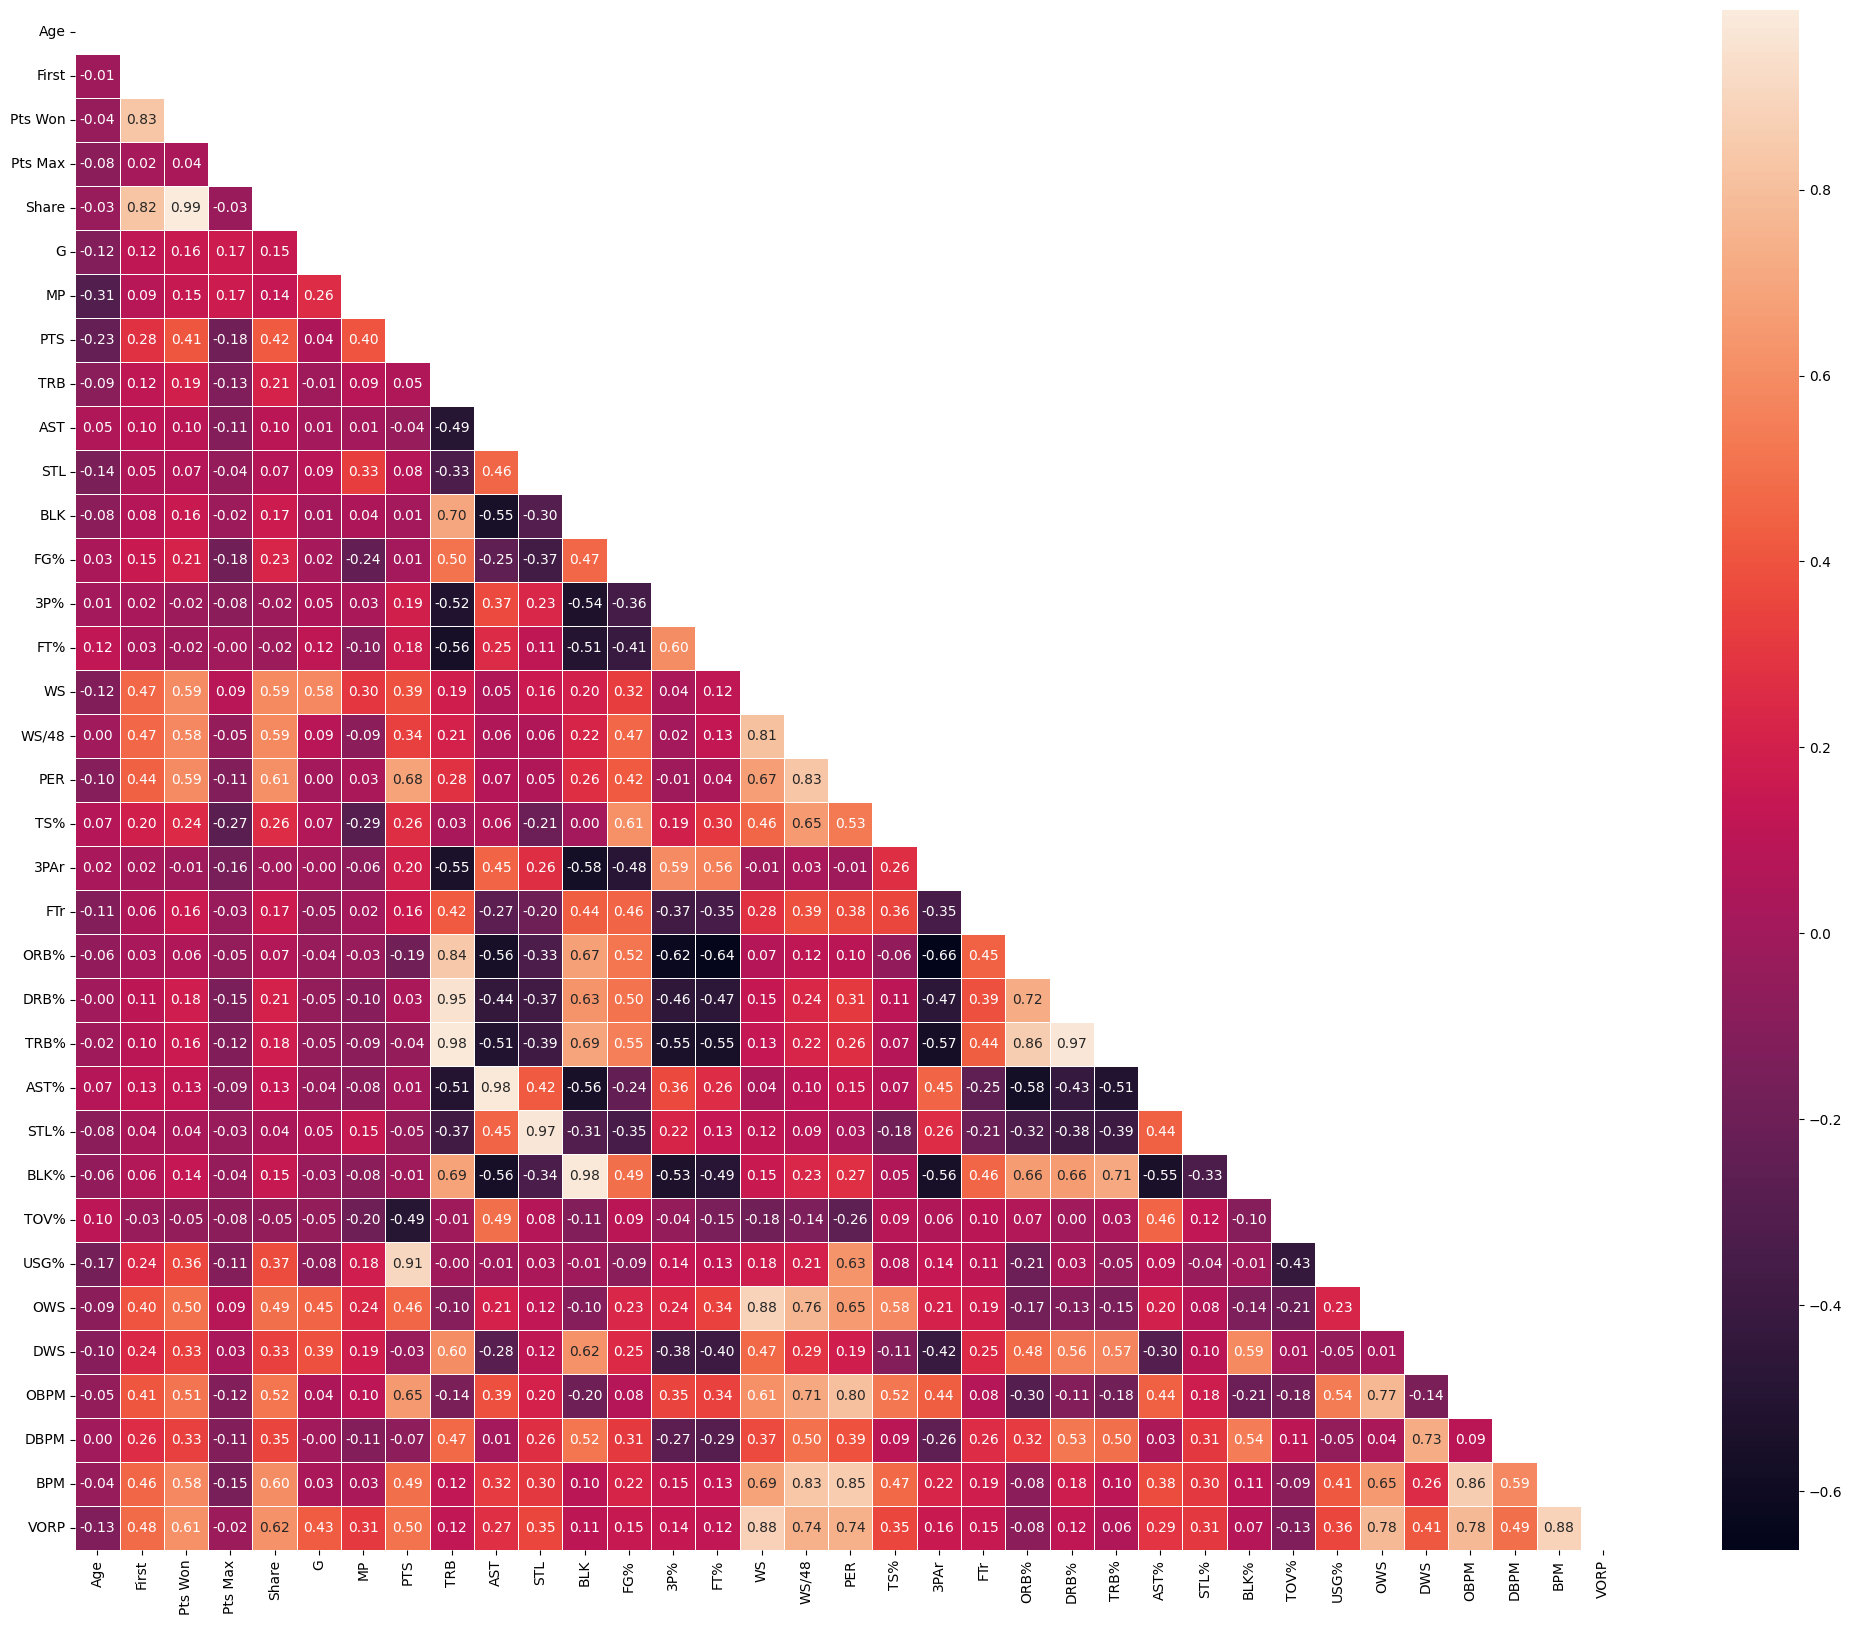

In [6]:
df_view = df[df.columns[:-1]]
corr = df_view.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))

plt.figure(figsize=(25,20), edgecolor="#04253a")
sns.heatmap(corr, annot=True, mask=mask, linewidths=.5, fmt=".2f")
plt.savefig('assets/corr-matrix.png')
plt.show()

In [7]:
stats = ['PTS', 'WS', 'WS/48', 'PER', 'TS%', 'USG%', 'OWS', 'DWS', 'OBPM', 'DBPM', 'BPM', 'VORP']

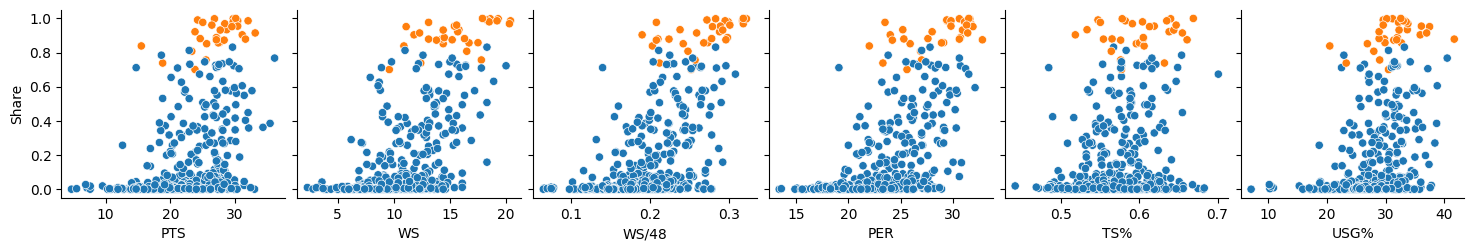

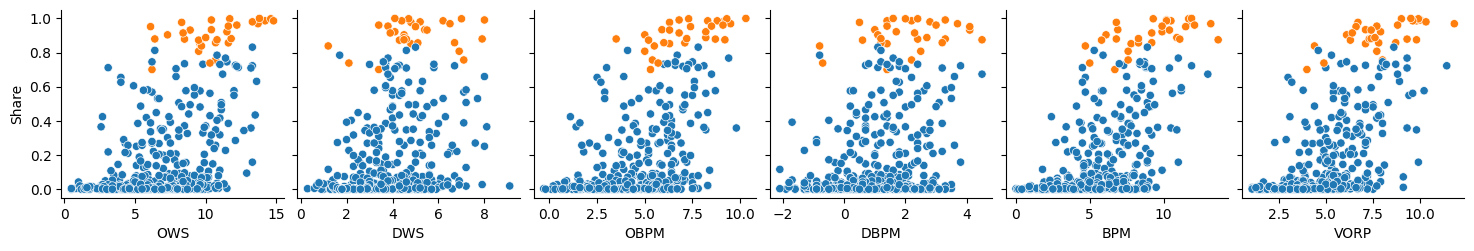

In [8]:
columns = df.columns.tolist()
sns.pairplot(df, x_vars=stats[:6], y_vars=['Share'], hue='Won')._legend.remove()
plt.savefig('assets/scatters-1.png')
sns.pairplot(df, x_vars=stats[6:], y_vars=['Share'], hue='Won')._legend.remove()
plt.savefig('assets/scatters-2.png')
plt.show()

In [9]:
X = df[stats].to_numpy()
X.shape

(462, 12)

In [10]:
y = df['Share'].to_numpy()
y.shape

(462,)

In [11]:
X = scale(X)
X

array([[ 0.57207554,  1.09736228,  0.97627999, ...,  0.32582557,
         0.89949827,  1.06205372],
       [ 0.66770434,  1.52082981,  0.80668369, ...,  2.02849453,
         0.78155081,  1.41746367],
       [ 1.91087884,  1.94429734,  1.56986704, ...,  1.25455409,
         2.2362361 ,  2.63601206],
       ...,
       [ 0.45732097, -1.01997536, -1.05887559, ..., -1.45423743,
        -1.18424011, -1.17195166],
       [ 0.26606335, -0.62675551, -0.44408901, ..., -1.14466125,
        -0.63381865, -0.76576887],
       [ 0.6868301 , -1.44344288, -1.01647652, ..., -0.37072082,
         0.07386608, -0.61345032]])

In [12]:
models = []
lr = LinearRegression()
lr.fit(X, y)
models.append(lr)

In [13]:
rfr = RandomForestRegressor(n_estimators=100, random_state=42)
rfr.fit(X, y)
models.append(rfr)

In [14]:
svr = SVR(epsilon=0.01)
svr.fit(X, y)
models.append(svr)

In [15]:
mlp = MLPRegressor(random_state=42, max_iter=1000)
mlp.fit(X, y)
models.append(mlp)

In [16]:
r1 = LinearRegression()
r2 = RandomForestRegressor(n_estimators=100, random_state=42)
r3 = KNeighborsRegressor()

er1 = VotingRegressor([('lr', r1), ('rf', r2), ('r3', r3)])
er1.fit(X, y)
models.append(er1)

In [17]:
reg1 = GradientBoostingRegressor(random_state=42)
reg2 = RandomForestRegressor(n_estimators=100, random_state=42)
reg3 = LinearRegression()

er2 = VotingRegressor(estimators=[('gb', reg1), ('rf', reg2), ('lr', reg3)])
er2.fit(X, y)
models.append(er2)

In [18]:
def acc(model, dfs):
    correct = 0
    for df in dfs:
        X = df[stats].replace(np.NaN, 0).to_numpy()
        X = scale(X)
        if np.argmax(model.predict(X)) == 0:
            correct += 1
    return correct / len(dfs)

In [19]:
scores = []
accs = []
for model in models:
    scores.append(model.score(X, y))
    accs.append(acc(model, dfs))
accs, scores

([0.6451612903225806,
  0.6129032258064516,
  0.7096774193548387,
  0.6451612903225806,
  0.6129032258064516,
  0.6129032258064516],
 [0.4792558660094782,
  0.9356455680253357,
  0.6631698292395414,
  0.7025817265767036,
  0.7594567149558111,
  0.8333591789626081])

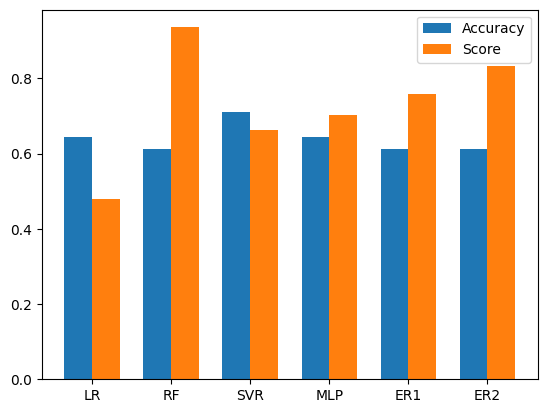

In [20]:
model_names = ['LR', 'RF', 'SVR', 'MLP', 'ER1', 'ER2']
bar_width = 0.35
index = np.arange(len(model_names))

plt.bar(index, accs, width=bar_width, label='Accuracy')
plt.bar(index + bar_width, scores, width=bar_width, label='Score')

plt.xticks(index + bar_width / 2, model_names)
plt.legend()
plt.savefig('assets/scores.png')
plt.show()